In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, classification_report,
    confusion_matrix, precision_recall_curve, roc_curve
)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

<font color = "green">-------------------------------------------------<font>

<font color = "green">EXPLORACION INICIAL<font>

<font color = "green">-------------------------------------------------<font>

In [2]:
df = pd.read_csv('creditcard.csv')
df.shape

(284807, 31)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19898 entries, 0 to 19897
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    19898 non-null  int64  
 1   V1      19898 non-null  float64
 2   V2      19898 non-null  float64
 3   V3      19898 non-null  float64
 4   V4      19898 non-null  float64
 5   V5      19898 non-null  float64
 6   V6      19898 non-null  float64
 7   V7      19898 non-null  float64
 8   V8      19898 non-null  float64
 9   V9      19898 non-null  float64
 10  V10     19898 non-null  float64
 11  V11     19897 non-null  float64
 12  V12     19897 non-null  float64
 13  V13     19897 non-null  float64
 14  V14     19897 non-null  float64
 15  V15     19897 non-null  float64
 16  V16     19897 non-null  float64
 17  V17     19897 non-null  float64
 18  V18     19897 non-null  float64
 19  V19     19897 non-null  float64
 20  V20     19897 non-null  float64
 21  V21     19897 non-null  float64
 22

In [22]:
df.duplicated().sum()

np.int64(1081)

In [3]:
df = df.drop_duplicates()
df.shape

(283726, 31)

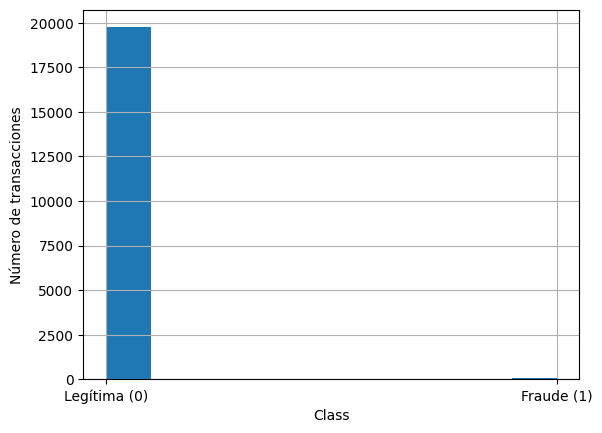

In [9]:
df["Class"].hist()
plt.xlabel("Class")
plt.ylabel("Número de transacciones")
plt.xticks([0, 1], ["Legítima (0)", "Fraude (1)"])
plt.show()

In [10]:
df['Class'].value_counts()

,count
Class,
0.0,19743
1.0,85


In [11]:
porcentaje = df['Class'].value_counts(normalize=True) * 100
print(porcentaje)

Class
0.0    99.571313
1.0     0.428687
Name: proportion, dtype: float64


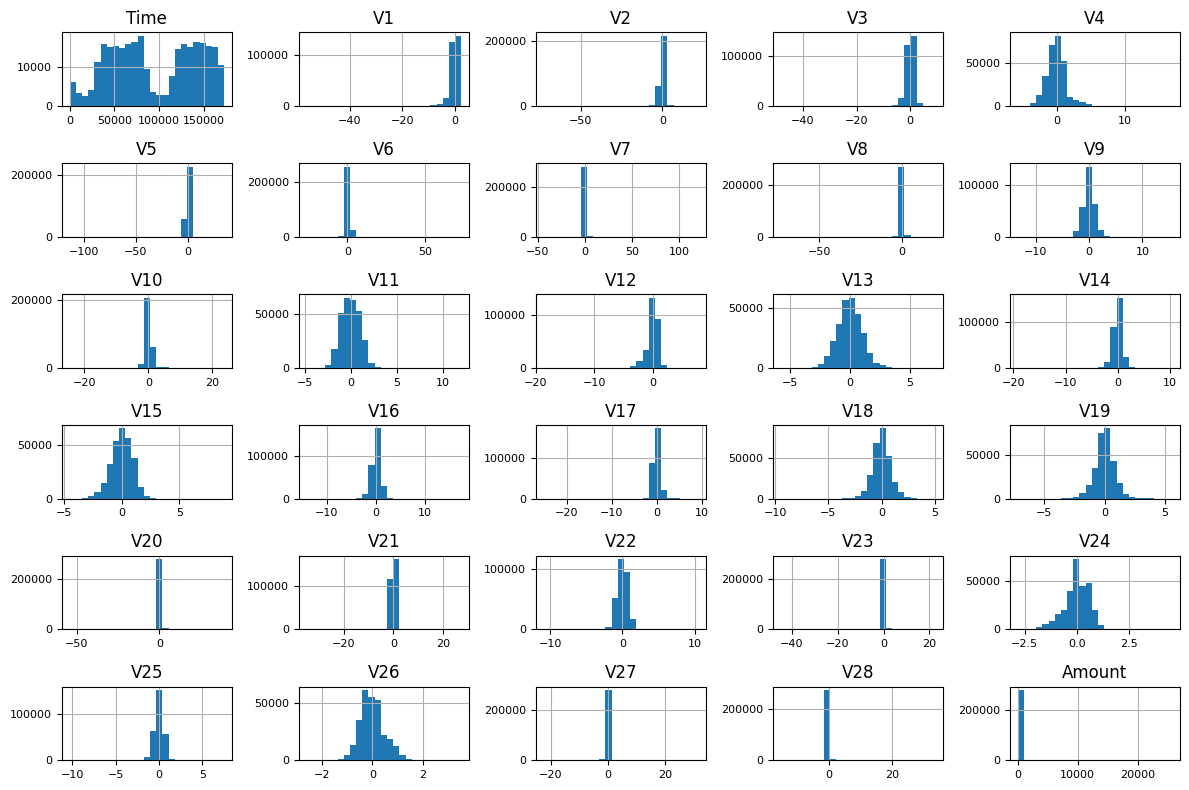

In [20]:
df.drop(columns= ['Class']).hist(figsize=(12, 8), bins=25, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

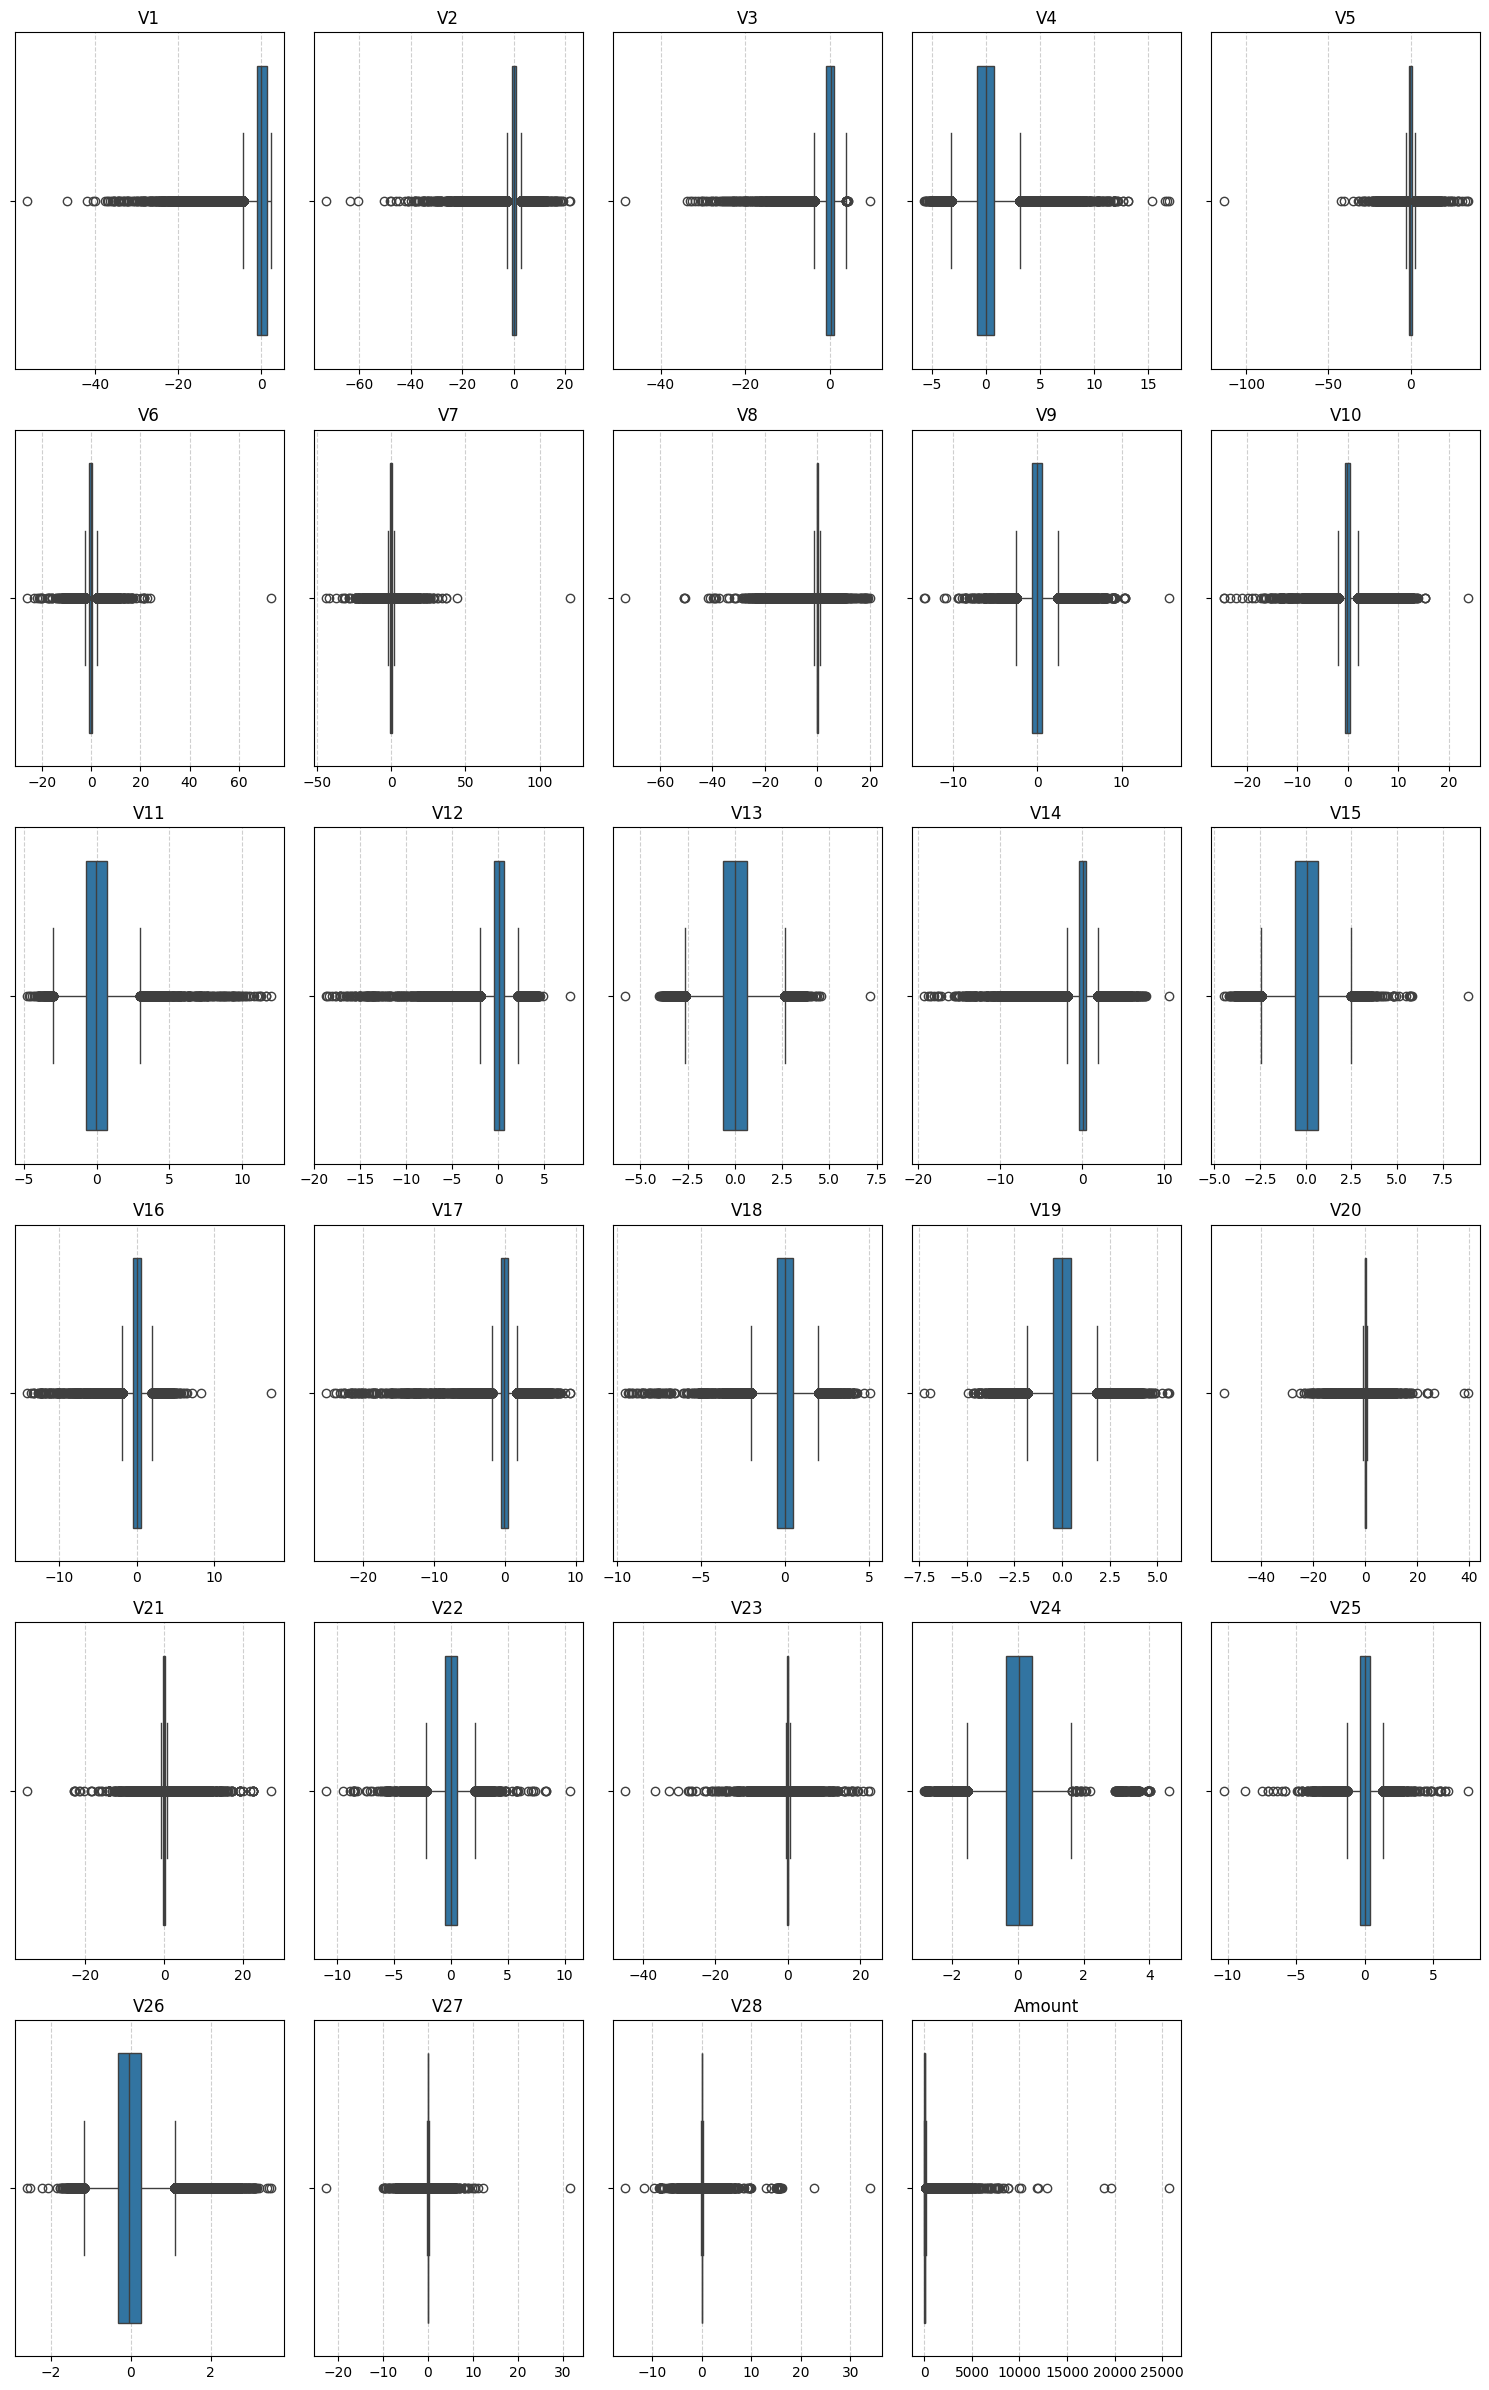

In [25]:
df_box = df.drop(columns= ['Time','Class'])

num_vars = len(df_box.columns)

ncols = 5
nrows = math.ceil(num_vars / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4*nrows))
axes = axes.flatten()

for i, col in enumerate(df_box.columns):
    sns.boxplot(x=df_box[col], ax=axes[i])
    axes[i].set_title(f"{col}")
    axes[i].set_xlabel("")
    axes[i].grid(True, axis="x", linestyle="--", alpha=0.6)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

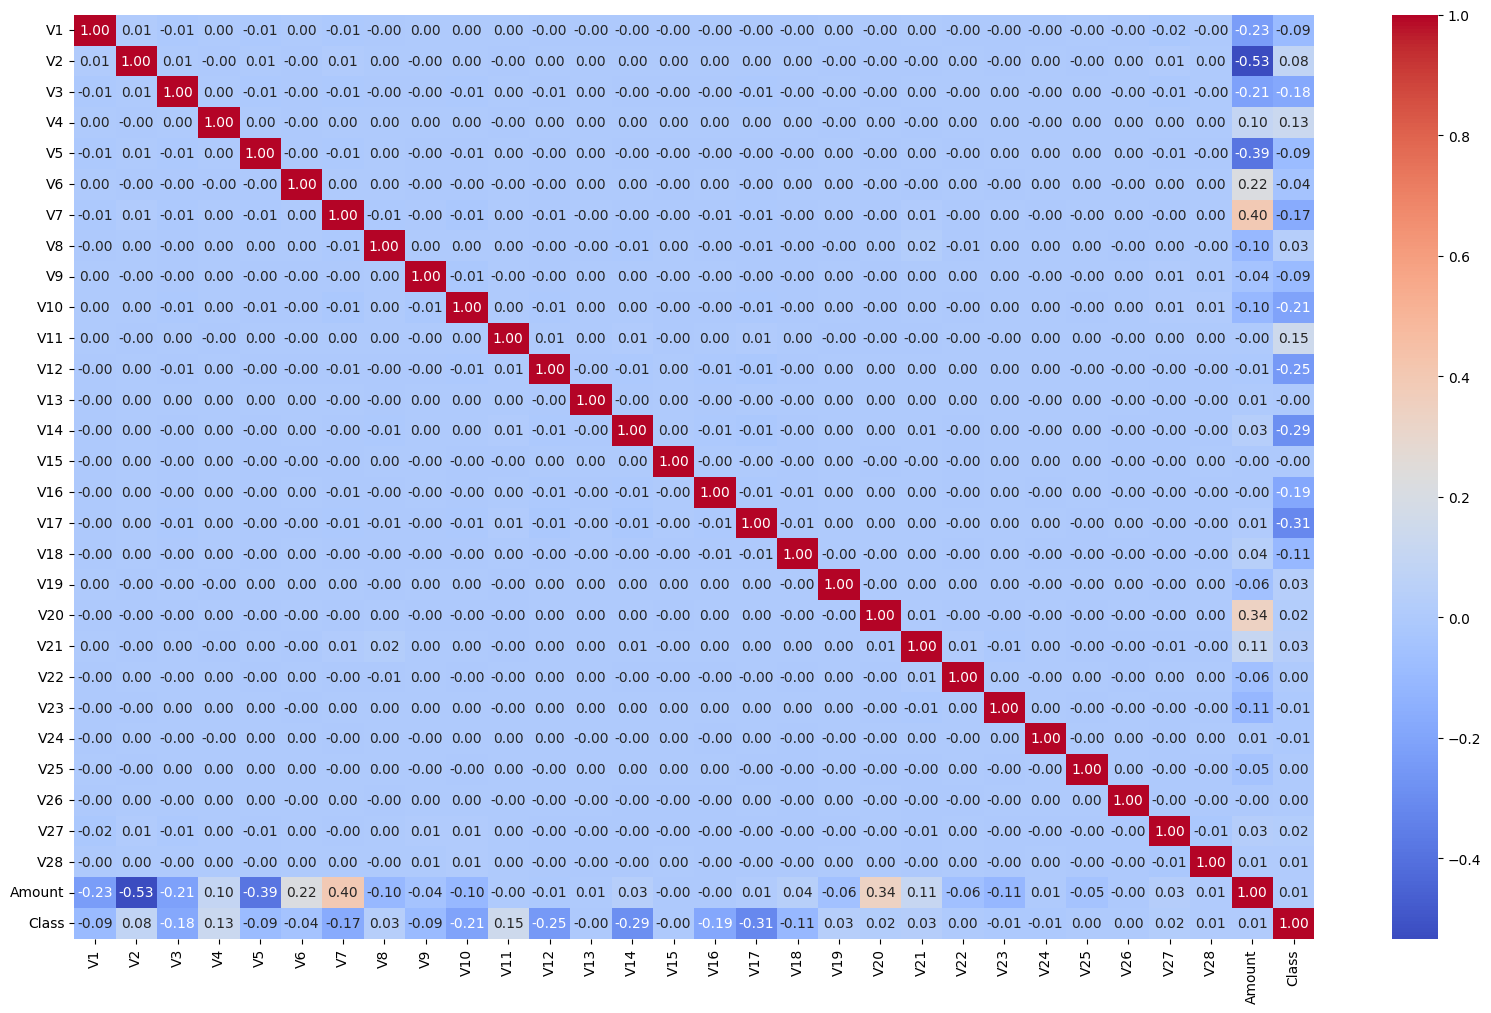

In [30]:
num_vars = df.select_dtypes(include=['float64','int64']).drop(columns= ['Time'])
corr = num_vars.corr()

plt.figure(figsize=(20,12))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.show()

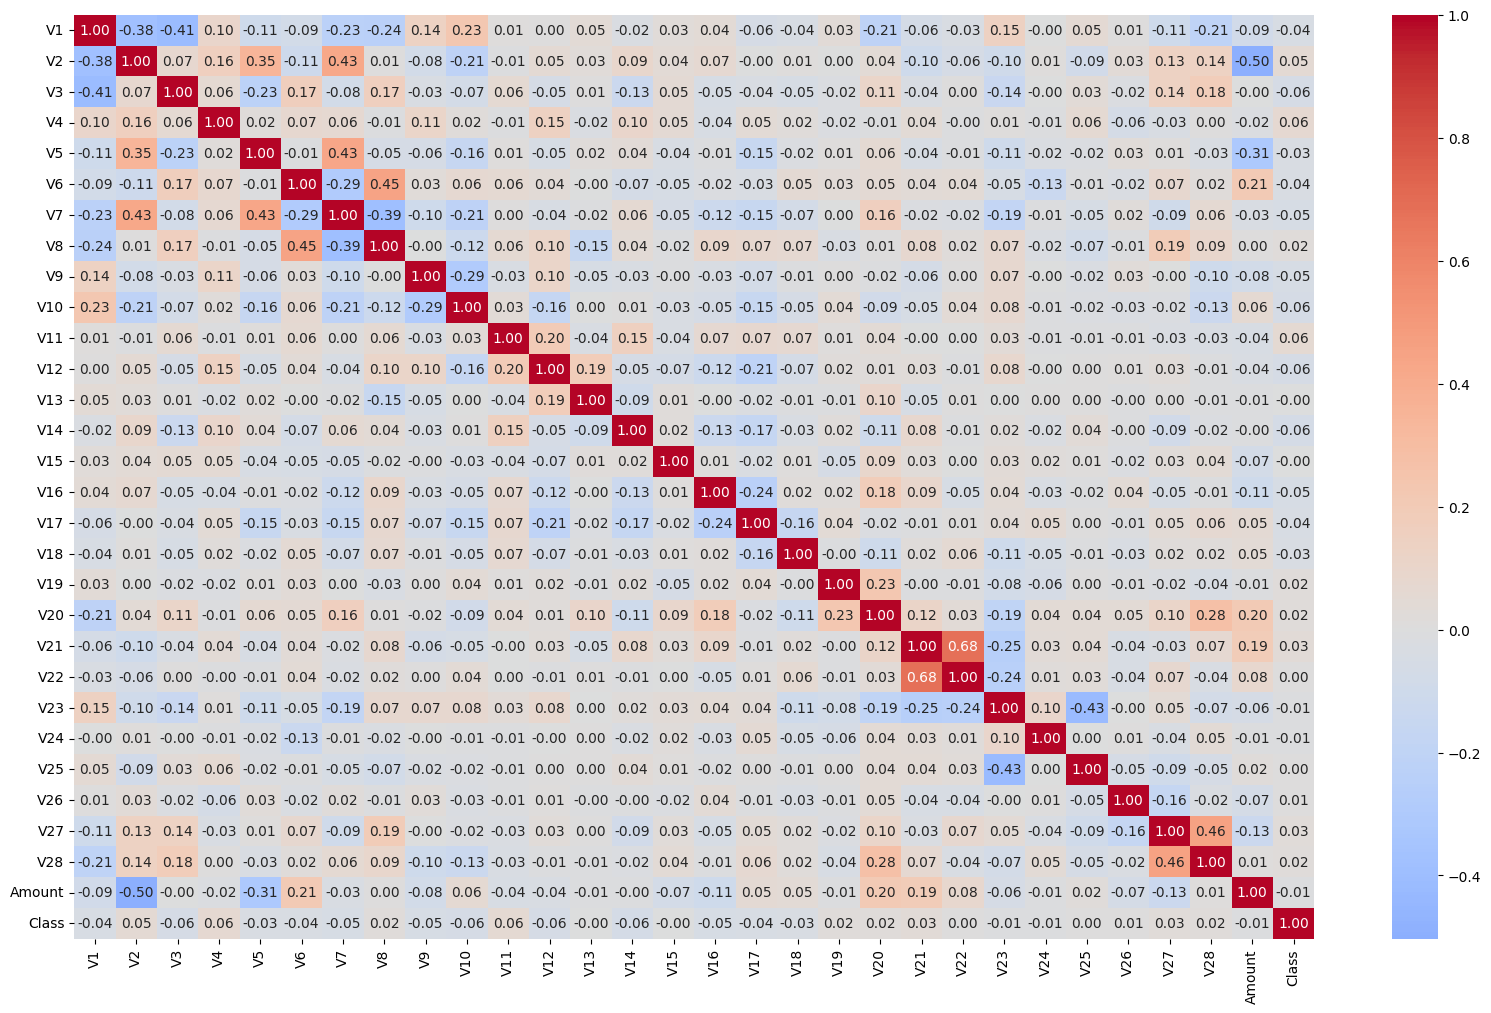

In [31]:
corr_pred = num_vars.corr(method="spearman")

plt.figure(figsize=(20, 12))
sns.heatmap(corr_pred, annot = True, cmap="coolwarm", fmt=".2f", center=0, cbar=True)

plt.show()

<font color = "green">-------------------------------------------------<font>

<font color = "green">PREPROCESAMIENTO<font>

<font color = "green">-------------------------------------------------<font>

In [4]:
# Eliminar la variable Time
df = df.drop(columns= ['Time'])

In [5]:
# Normalizar variable Amount
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

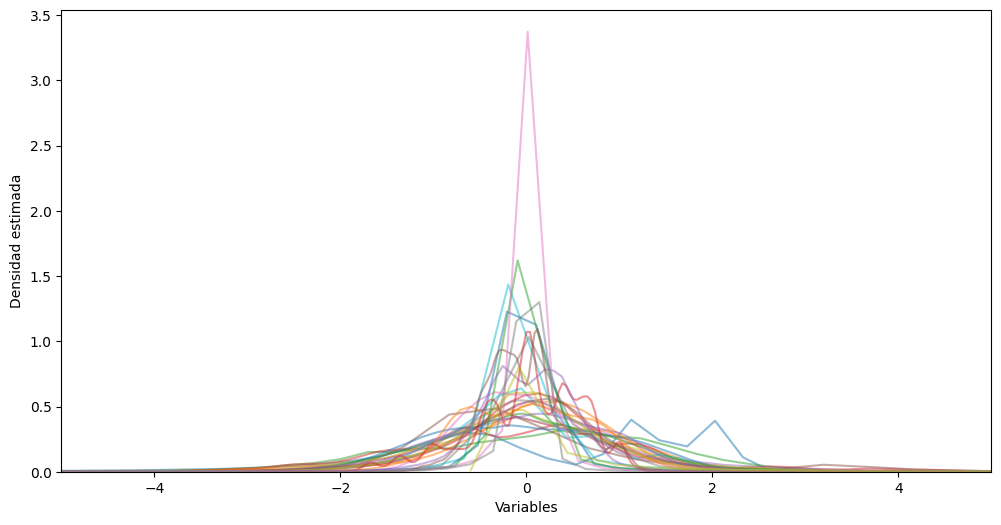

In [18]:
vars_to_plot = [f'V{i}' for i in range(1,29)] + ['Amount']

plt.figure(figsize=(12,6))
for col in vars_to_plot:
    sns.kdeplot(df[col], label=col, alpha=0.5)
plt.xlim(-5, 5)
plt.xlabel("Variables")
plt.ylabel("Densidad estimada")
plt.show()

In [28]:
df['Class'].value_counts()

,count
Class,
0,283253
1,473


In [29]:
porcentaje = df['Class'].value_counts(normalize=True) * 100
print(porcentaje)

Class
0    99.83329
1     0.16671
Name: proportion, dtype: float64


In [8]:
# Undersampling del 5% de la clase 0
fraudes = df[df["Class"] == 1]
no_fraudes = df[df["Class"] == 0].sample(frac=0.05, random_state=42)

df_reducido = pd.concat([fraudes, no_fraudes])

X_reducido = df_reducido.drop("Class", axis=1)
y_reducido = df_reducido["Class"]

print("Distribución tras undersampling:")
print(y_reducido.value_counts())

# SMOTE para conseguir ratio 1:5
smote = SMOTE(sampling_strategy=0.2, random_state=42)

X_balanceado, y_balanceado = smote.fit_resample(X_reducido, y_reducido)

print("\nDistribución final después de SMOTE:")
print(y_balanceado.value_counts())

Distribución tras undersampling:
Class
0    14163
1      473
Name: count, dtype: int64

Distribución final después de SMOTE:
Class
0    14163
1     2832
Name: count, dtype: int64


In [9]:
# Reconstruir el df ahora balanceado
df_balanceado = pd.DataFrame(X_balanceado, columns=X_reducido.columns)
df_balanceado["Class"] = y_balanceado

print(df_balanceado.shape)
print(df_balanceado["Class"].value_counts())

(16995, 30)
Class
0    14163
1     2832
Name: count, dtype: int64


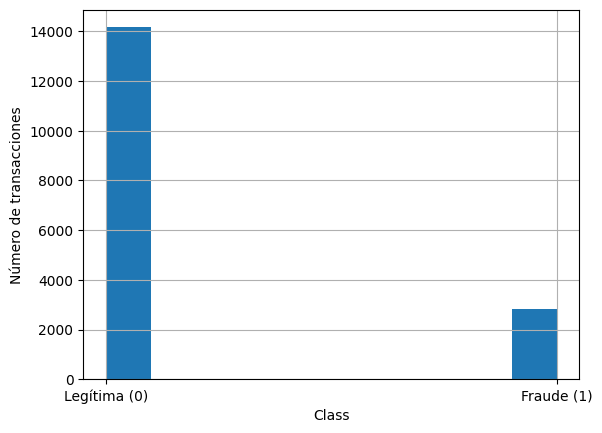

In [44]:
df_balanceado["Class"].hist()
plt.xlabel("Class")
plt.ylabel("Número de transacciones")
plt.xticks([0, 1], ["Legítima (0)", "Fraude (1)"])
plt.show()

In [10]:
# Train test split
X = df_balanceado.drop("Class", axis=1)
y = df_balanceado["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Tamaño entrenamiento:", X_train.shape)
print("Tamaño test:", X_test.shape)
print("Distribución clases en train:\n", y_train.value_counts(normalize=True))
print("Distribución clases en test:\n", y_test.value_counts(normalize=True))

Tamaño entrenamiento: (13596, 29)
Tamaño test: (3399, 29)
Distribución clases en train:
 Class
0    0.833333
1    0.166667
Name: proportion, dtype: float64
Distribución clases en test:
 Class
0    0.83348
1    0.16652
Name: proportion, dtype: float64


In [22]:
def evaluate_model(model, X_train, y_train, X_test, y_test, th, name="model", plot_curves=True):
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= th).astype(int)

    metrics = {
        "name": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_prob),
        "avg_precision": average_precision_score(y_test, y_prob)
    }
    print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap="Blues", values_format="d")
    plt.show()

    if plot_curves:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        prec, rec, _ = precision_recall_curve(y_test, y_prob)
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(fpr, tpr, label=f'ROC AUC = {metrics["roc_auc"]:.3f}')
        plt.plot([0,1],[0,1],'k--',alpha=0.3)
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()
        plt.tight_layout()
        plt.show()

<font color = "green">-------------------------------------------------<font>

<font color = "green">REGRESIÓN LOGÍSTICA<font>

<font color = "green">-------------------------------------------------<font>


Classification report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      2833
           1       0.95      0.88      0.92       566

    accuracy                           0.97      3399
   macro avg       0.97      0.94      0.95      3399
weighted avg       0.97      0.97      0.97      3399



<Figure size 800x600 with 0 Axes>

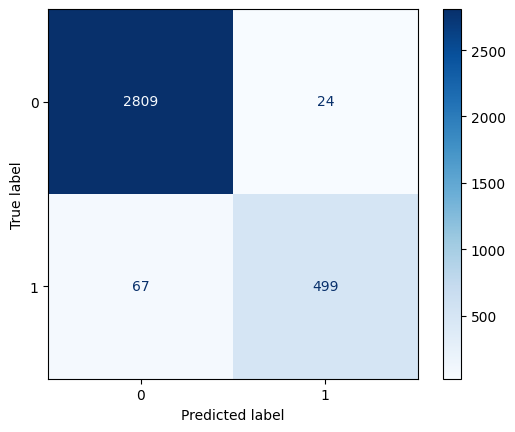

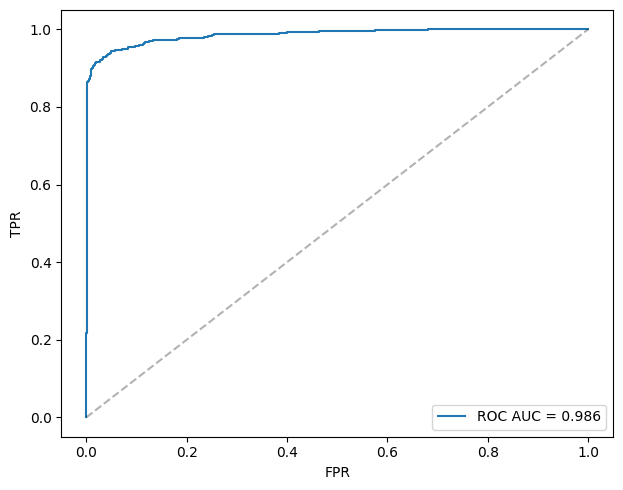

In [35]:
lr_simple = LogisticRegression(max_iter=2000, random_state=42, solver='liblinear')

evaluate_model(
    lr_simple, X_train, y_train, X_test, y_test, 0.5, name="LogReg_simple"
)

In [44]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'max_iter': [1000,2000]
}

grid = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

grid.fit(X_train, y_train)

best_lr = grid.best_estimator_
print("Mejores parámetros:", grid.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Mejores parámetros: {'C': 10, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}



Classification report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      2833
           1       0.96      0.88      0.92       566

    accuracy                           0.97      3399
   macro avg       0.97      0.94      0.95      3399
weighted avg       0.97      0.97      0.97      3399



<Figure size 800x600 with 0 Axes>

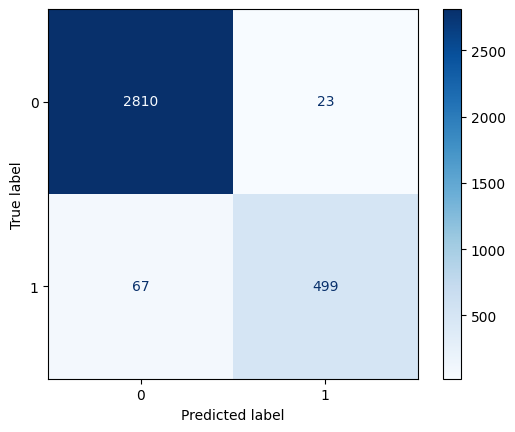

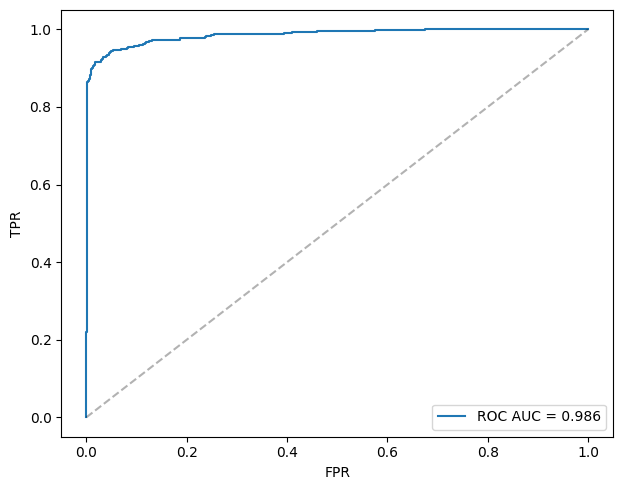

In [45]:
evaluate_model(
    best_lr, X_train, y_train, X_test, y_test, 0.5, name="LogReg_opt"
)

<font color = "green">-------------------------------------------------<font>

<font color = "green">KNN<font>

<font color = "green">-------------------------------------------------<font>

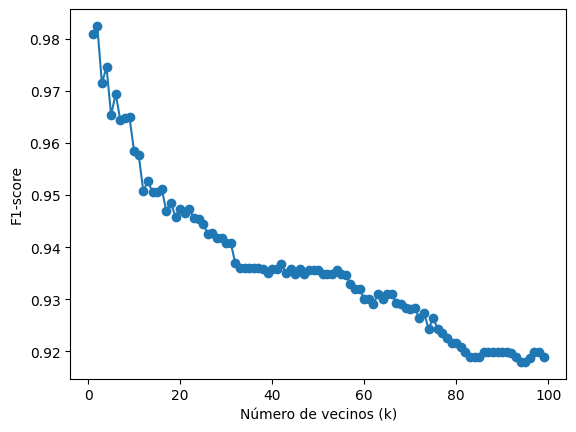

In [49]:
neighbors = range(1, 100)
f1_scores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    f1_scores.append(f1_score(y_test, y_pred))

plt.plot(neighbors, f1_scores, marker='o')
plt.xlabel("Número de vecinos (k)")
plt.ylabel("F1-score")
plt.show()

In [55]:
param_grid = {
    "n_neighbors": [2,20,40,80],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan", "minkowski"],

}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
knn = KNeighborsClassifier(n_jobs=-1)
grid_knn = GridSearchCV(knn, param_grid, cv=cv, scoring="f1", n_jobs=-1, verbose=1, refit=True)
grid_knn.fit(X_train, y_train)

print("Mejores parámetros:", grid_knn.best_params_)
best_knn = grid_knn.best_estimator_

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Mejores parámetros: {'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'uniform'}



Classification report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      2833
           1       0.94      1.00      0.97       566

    accuracy                           0.99      3399
   macro avg       0.97      0.99      0.98      3399
weighted avg       0.99      0.99      0.99      3399



<Figure size 800x600 with 0 Axes>

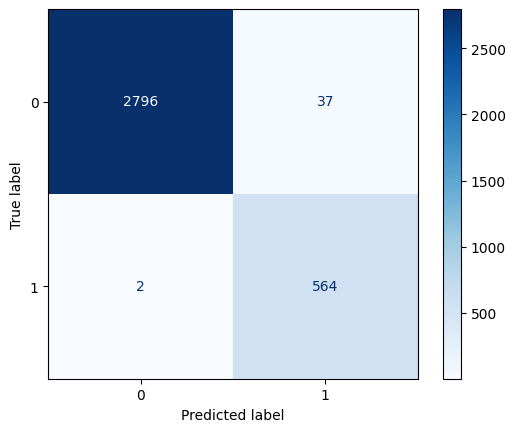

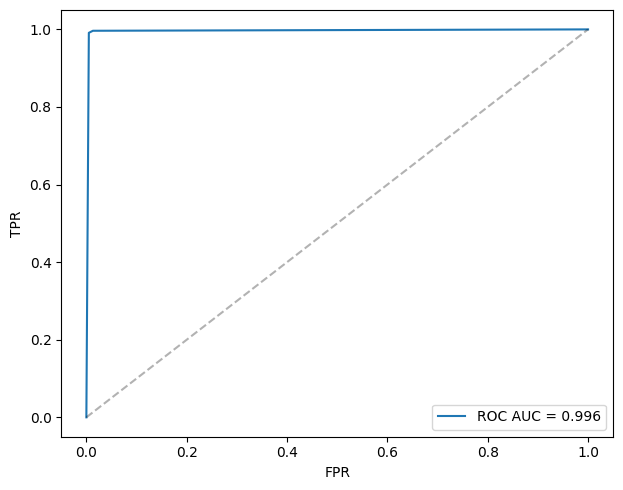

In [56]:
evaluate_model(
    best_knn, X_train, y_train, X_test, y_test, 0.5,  name="KNN_opt"
)

<font color = "green">-------------------------------------------------<font>

<font color = "green">SVM<font>

<font color = "green">-------------------------------------------------<font>


Classification report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      2833
           1       0.96      0.87      0.91       566

    accuracy                           0.97      3399
   macro avg       0.97      0.93      0.95      3399
weighted avg       0.97      0.97      0.97      3399



<Figure size 800x600 with 0 Axes>

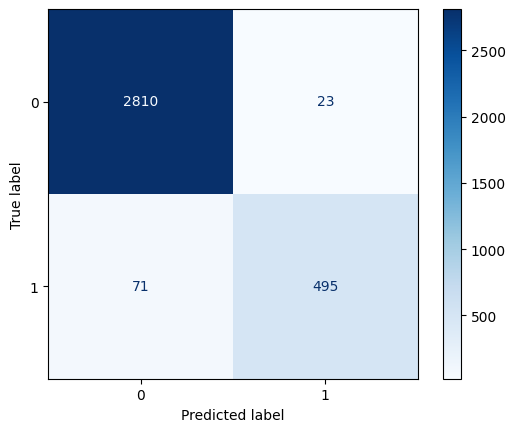

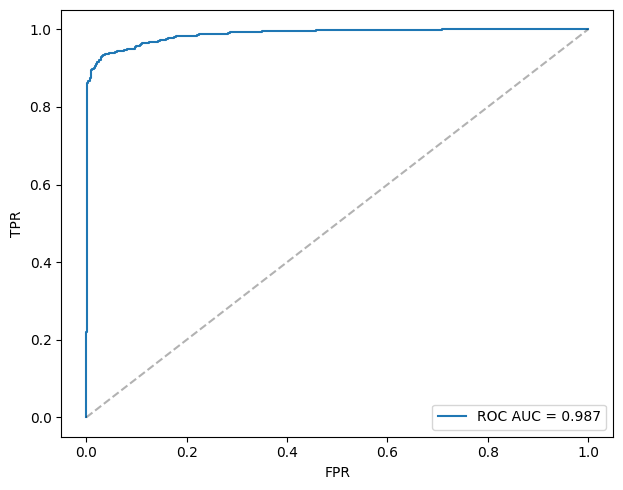

In [30]:
linear_svc = LinearSVC(C=1.0, max_iter=5000, random_state=42)
linear_svc_calibrated = CalibratedClassifierCV(linear_svc)

evaluate_model(
    linear_svc_calibrated, X_train, y_train, X_test, y_test, 0.5, name="SVM_linear"
)

In [31]:
param_grid = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", 0.1, 0.01],
    "kernel": ["rbf","linear",'poly','sigmoid']
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_svm = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_svm.fit(X_train, y_train)

print("Mejores parámetros:", grid_svm.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mejores parámetros: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}



Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2833
           1       0.98      0.98      0.98       566

    accuracy                           0.99      3399
   macro avg       0.99      0.99      0.99      3399
weighted avg       0.99      0.99      0.99      3399



<Figure size 800x600 with 0 Axes>

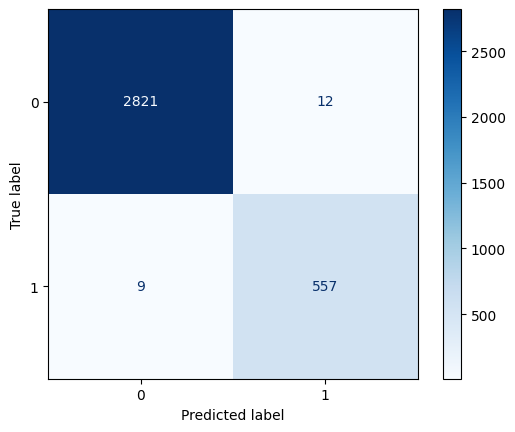

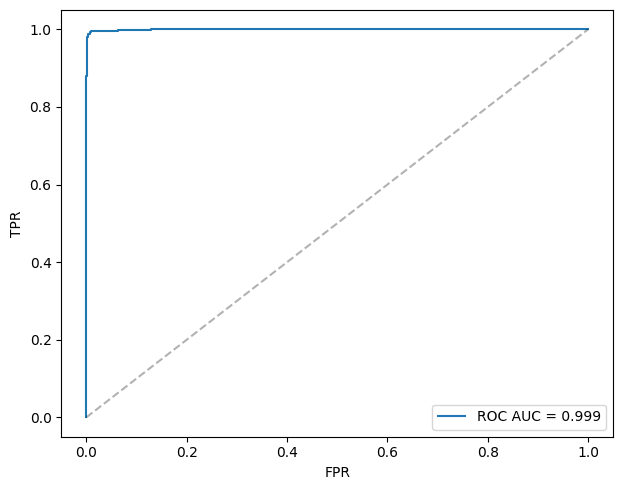

In [32]:
best_svm = grid_svm.best_estimator_

evaluate_model(
    best_svm, X_train, y_train, X_test, y_test, 0.5, name="SVM_linear"
)

<font color = "green">-------------------------------------------------<font>

<font color = "green">RANDOM FOREST<font>

<font color = "green">-------------------------------------------------<font>

In [27]:
param_dist = {
    "n_estimators": [100, 300, 500],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt"],
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=30,
    scoring="f1",
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Mejores parámetros RandomSearch:", random_search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Mejores parámetros RandomSearch: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}


In [28]:
param_grid = {
    "n_estimators": [80, 100, 120],
    "max_depth": [None, 20],
    "min_samples_split": [2],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt"],
}

grid_search = GridSearchCV(
    rf,
    param_grid,
    scoring="f1",
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Mejores parámetros GridSearch:", grid_search.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Mejores parámetros GridSearch: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}



Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2833
           1       0.99      0.96      0.98       566

    accuracy                           0.99      3399
   macro avg       0.99      0.98      0.99      3399
weighted avg       0.99      0.99      0.99      3399



<Figure size 800x600 with 0 Axes>

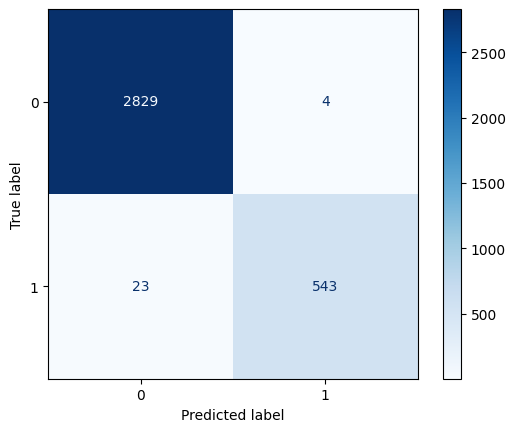

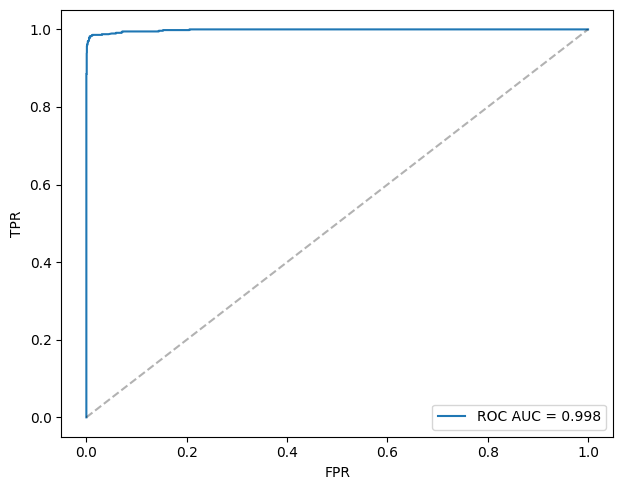

In [29]:
best_rf = grid_search.best_estimator_

evaluate_model(
    best_rf, X_train, y_train, X_test, y_test, 0.5, name="RF_opt"
)

<font color = "green">-------------------------------------------------<font>

<font color = "green">XGBOOST<font>

<font color = "green">-------------------------------------------------<font>

In [30]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 20.5 MB/s eta 0:00:00


In [33]:
import optuna

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 10),
        "random_state": 42,
        "n_jobs": -1,
        "tree_method": "hist",
        "eval_metric": "logloss"
    }

    model = XGBClassifier(**params)

    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    preds = model.predict(X_test)
    f1 = f1_score(y_test, preds)

    return f1

In [34]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, show_progress_bar=True)

print("Mejores parámetros:", study.best_trial.params)
print("Mejor F1:", study.best_value)

[I 2025-09-03 12:55:17,500] A new study created in memory with name: no-name-009ab9e8-fceb-4ccf-9dd3-299c59117c5b


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-09-03 12:55:18,325] Trial 0 finished with value: 0.9813994685562445 and parameters: {'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.18934802647247037, 'subsample': 0.6748745666469995, 'colsample_bytree': 0.5687500806388174, 'gamma': 1.6930752890937701, 'min_child_weight': 6, 'scale_pos_weight': 5.145325717008023}. Best is trial 0 with value: 0.9813994685562445.
[I 2025-09-03 12:55:20,072] Trial 1 finished with value: 0.9703832752613241 and parameters: {'n_estimators': 876, 'max_depth': 2, 'learning_rate': 0.18667126843383972, 'subsample': 0.605271851247396, 'colsample_bytree': 0.8701926310910799, 'gamma': 4.50840154021643, 'min_child_weight': 8, 'scale_pos_weight': 8.426561624423831}. Best is trial 0 with value: 0.9813994685562445.
[I 2025-09-03 12:55:21,458] Trial 2 finished with value: 0.9814323607427056 and parameters: {'n_estimators': 491, 'max_depth': 11, 'learning_rate': 0.16877239442919537, 'subsample': 0.6236925287567621, 'colsample_bytree': 0.633759588509733, 


Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2833
           1       0.99      0.99      0.99       566

    accuracy                           1.00      3399
   macro avg       0.99      0.99      0.99      3399
weighted avg       1.00      1.00      1.00      3399



<Figure size 800x600 with 0 Axes>

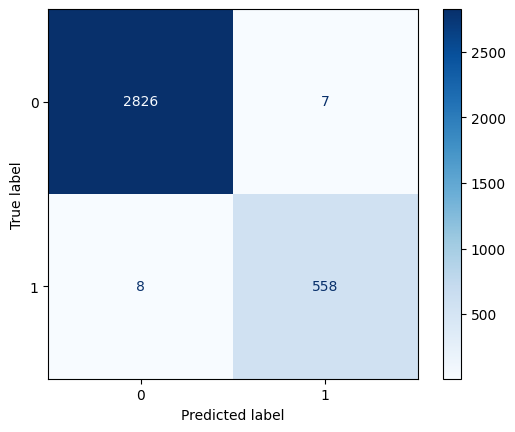

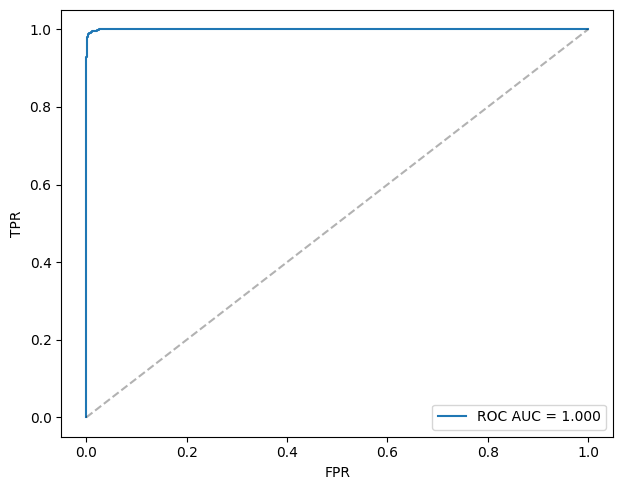

In [35]:
best_params = study.best_trial.params
best_xgb = XGBClassifier(**best_params)

evaluate_model(
    best_xgb, X_train, y_train, X_test, y_test, 0.5, name="RF_opt"
)

<font color = "green">-------------------------------------------------<font>

<font color = "green">EXPERIMENTOS ADICIONALES<font>

<font color = "green">-------------------------------------------------<font>

<font color = "green">-------------------------------------------------<font>

<font color = "green">XGBOOST<font>

<font color = "green">-------------------------------------------------<font>

In [29]:
xgb_model = XGBClassifier(
    n_estimators=301,
    max_depth=8,
    learning_rate=0.09825530111960241,
    subsample=0.7131739822347223,
    colsample_bytree=0.8119106082469287,
    gamma=0.02324521900643417,
    min_child_weight=1,
    scale_pos_weight=6.747450363799887,
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:50:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8119106082469287, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=0.02324521900643417, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09825530111960241,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=301, n_jobs=-1,
              num_parallel_tree=None, ...)


Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    283253
           1       0.46      1.00      0.63       473

    accuracy                           1.00    283726
   macro avg       0.73      1.00      0.82    283726
weighted avg       1.00      1.00      1.00    283726



<Figure size 800x600 with 0 Axes>

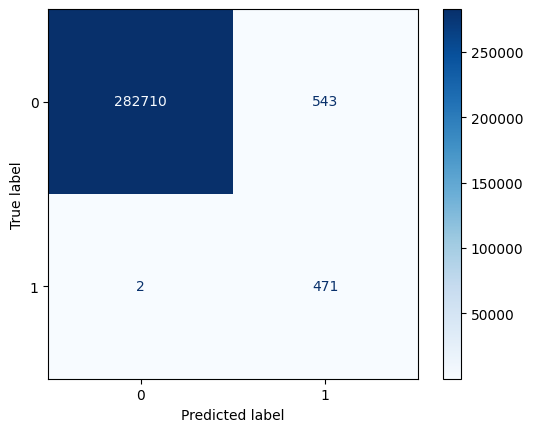

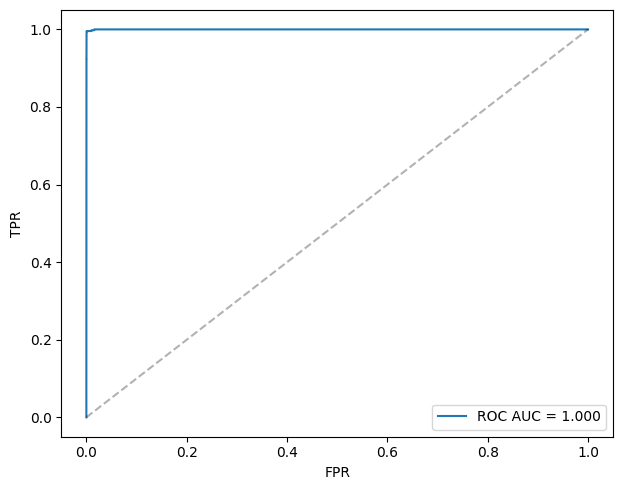

In [30]:
df_eval = df.copy()

y_true = df_eval["Class"]

X_all = df_eval.drop(columns=["Class"])

y_pred = xgb_model.predict(X_all)
y_prob = xgb_model.predict_proba(X_all)[:, 1]

auc = roc_auc_score(y_true, y_prob)

print("\nClassification report:\n", classification_report(y_true, y_pred, zero_division=0))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.show()

fpr, tpr, _ = roc_curve(y_true, y_prob)
prec, rec, _ = precision_recall_curve(y_true, y_prob)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f'ROC AUC = {auc:.3f}')
plt.plot([0,1],[0,1],'k--',alpha=0.3)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()
plt.tight_layout()
plt.show()

In [25]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

y_prob = xgb_model.predict_proba(X_test)[:, 1]

thresholds = np.arange(0, 1.01, 0.01)

precisions = []
recalls = []
f1s = []

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred_t))
    recalls.append(recall_score(y_test, y_pred_t))
    f1s.append(f1_score(y_test, y_pred_t))

best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
print(f"Mejor umbral: {best_threshold:.2f} con F1 = {f1s[best_idx]:.4f}")

Mejor umbral: 0.48 con F1 = 0.9885


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


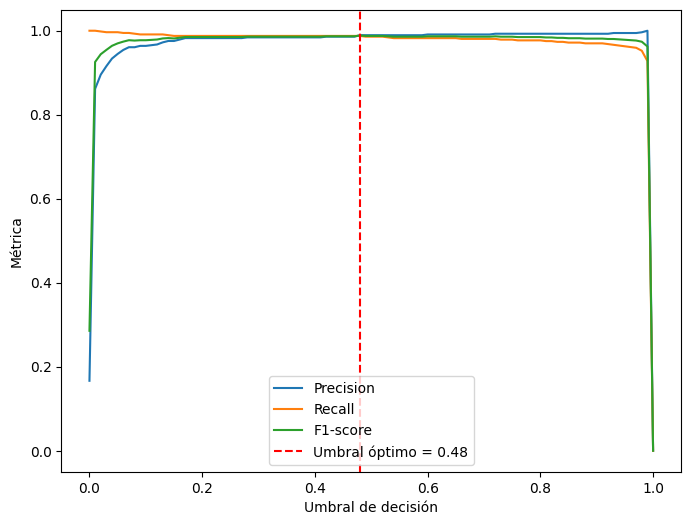

In [26]:
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1-score")
plt.axvline(best_threshold, color="red", linestyle="--", label=f"Umbral óptimo = {best_threshold:.2f}")
plt.xlabel("Umbral de decisión")
plt.ylabel("Métrica")
plt.legend()
plt.show()


Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    283253
           1       0.59      1.00      0.74       473

    accuracy                           1.00    283726
   macro avg       0.79      1.00      0.87    283726
weighted avg       1.00      1.00      1.00    283726



<Figure size 800x600 with 0 Axes>

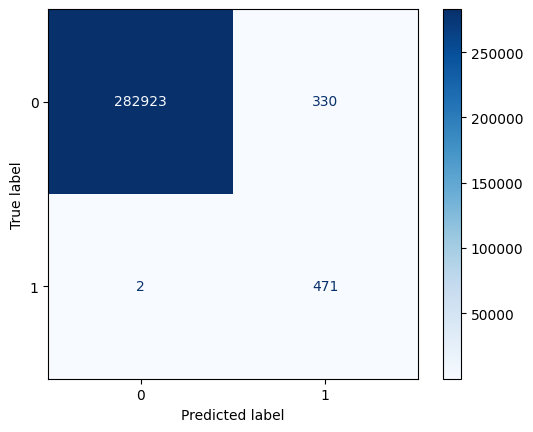

In [31]:
# Predicciones con umbral optimizado
y_pred_opt = (y_prob >= 0.75).astype(int)

print("\nClassification report:\n", classification_report(y_true, y_pred_opt, zero_division=0))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred_opt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.show()

<font color = "green">-------------------------------------------------<font>

<font color = "green">SVM<font>

<font color = "green">-------------------------------------------------<font>

In [15]:
from sklearn.svm import SVC

svm_model = SVC(
    C=10,
    gamma=0.1,
    kernel='rbf',
    probability=True,
    random_state=42
)

svm_model.fit(X_train, y_train)

SVC(C=10, gamma=0.1, probability=True, random_state=42)


Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    283253
           1       0.46      0.99      0.63       473

    accuracy                           1.00    283726
   macro avg       0.73      0.99      0.81    283726
weighted avg       1.00      1.00      1.00    283726



<Figure size 800x600 with 0 Axes>

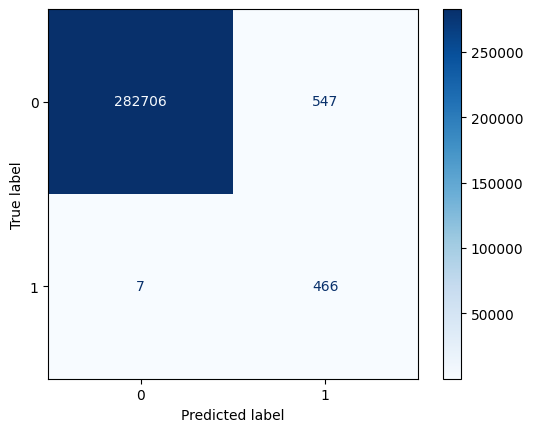

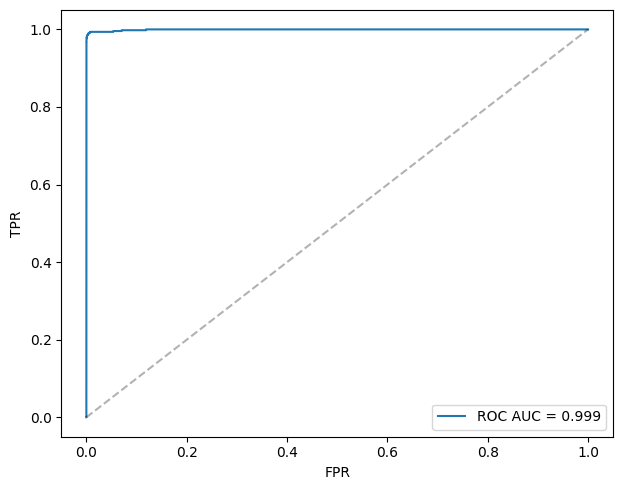

In [21]:
df_eval = df.copy()

y_true = df_eval["Class"]

X_all = df_eval.drop(columns=["Class"])

y_pred = svm_model.predict(X_all)
y_prob = svm_model.predict_proba(X_all)[:, 1]

auc = roc_auc_score(y_true, y_prob)

print("\nClassification report:\n", classification_report(y_true, y_pred, zero_division=0))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.show()

fpr, tpr, _ = roc_curve(y_true, y_prob)
prec, rec, _ = precision_recall_curve(y_true, y_prob)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f'ROC AUC = {auc:.3f}')
plt.plot([0,1],[0,1],'k--',alpha=0.3)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()
plt.tight_layout()
plt.show()


Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    283253
           1       0.55      0.98      0.71       473

    accuracy                           1.00    283726
   macro avg       0.78      0.99      0.85    283726
weighted avg       1.00      1.00      1.00    283726



<Figure size 800x600 with 0 Axes>

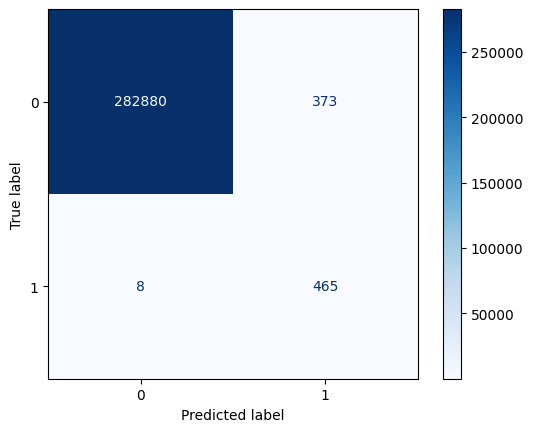

In [23]:
# Predicciones con umbral optimizado
y_pred_opt = (y_prob >= 0.75).astype(int)

print("\nClassification report:\n", classification_report(y_true, y_pred_opt, zero_division=0))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred_opt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.show()

In [17]:
y_prob = svm_model.predict_proba(X_test)[:, 1]

thresholds = np.arange(0, 1.01, 0.01)

precisions = []
recalls = []
f1s = []

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred_t))
    recalls.append(recall_score(y_test, y_pred_t))
    f1s.append(f1_score(y_test, y_pred_t))

best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
print(f"Mejor umbral: {best_threshold:.2f} con F1 = {f1s[best_idx]:.4f}")

Mejor umbral: 0.75 con F1 = 0.9849


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


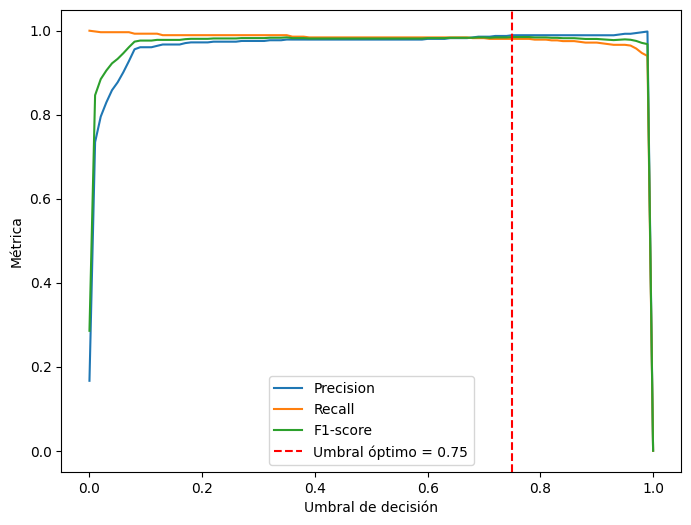

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1-score")
plt.axvline(best_threshold, color="red", linestyle="--", label=f"Umbral óptimo = {best_threshold:.2f}")
plt.xlabel("Umbral de decisión")
plt.ylabel("Métrica")
plt.legend()
plt.show()